# Sentiment Analysis for IMDB Movie Reviews
## Introduction
This project develops a sentiment analyzer for IMDB movie reviews, comparing the performance of various machine learning algorithms including Naïve Bayes, Support Vector Machine, and Logistic Regression. The goal is to accurately classify reviews as positive or negative.

### Install and Import Libraries

In [1]:
! pip install pandas numpy matplotlib seaborn scikit-learn nltk kagglehub kaggle wordcloud


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import warnings
import time
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

### Download NLTK resources


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kumssa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kumssa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading and Exploration

### Load the IMDB dataset

In [4]:
# Ensure the directory exists for the dataset
dataset_dir = "imdb_dataset"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Download the dataset from Kaggle using the kaggle CLI
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p {dataset_dir} --unzip

# Now load the dataset using pandas
print(f"Dataset downloaded to: {dataset_dir}")
df = pd.read_csv(f"{dataset_dir}/IMDB Dataset.csv")
print("First 5 records:")
print(df.head())

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
Dataset downloaded to: imdb_dataset
First 5 records:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Basic Data Exploration


In [5]:
print(f"Dataset shape: {df.shape}")
print("\nColumn information:")
print(df.info())
print("\nClass distribution:")
print(df['sentiment'].value_counts())
print("\nChecking for missing values:")
print(df.isnull().sum())

Dataset shape: (50000, 2)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Checking for missing values:
review       0
sentiment    0
dtype: int64


### Data Visualization - Distribution of Sentiments


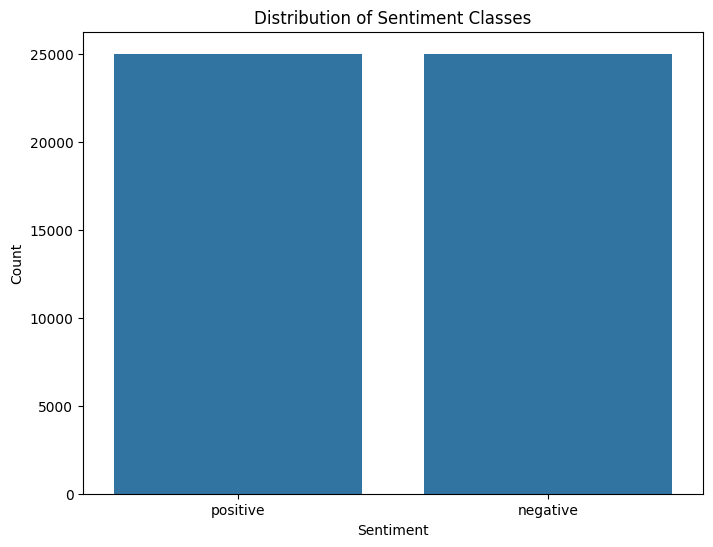

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Text Preprocessing Function


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)


### Apply Preprocessing

In [8]:

print("Preprocessing text data...")
start_time = time.time()
df['processed_text'] = df['review'].apply(preprocess_text)
print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")

Preprocessing text data...
Preprocessing completed in 64.52 seconds


### Explore processed text


In [9]:
print("\nOriginal vs Processed text example:")
print(f"Original: {df['review'][0][:200]}...")
print(f"Processed: {df['processed_text'][0][:200]}...")


Original vs Processed text example:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Processed: one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug s...


Enhanced data analysis after preprocessing

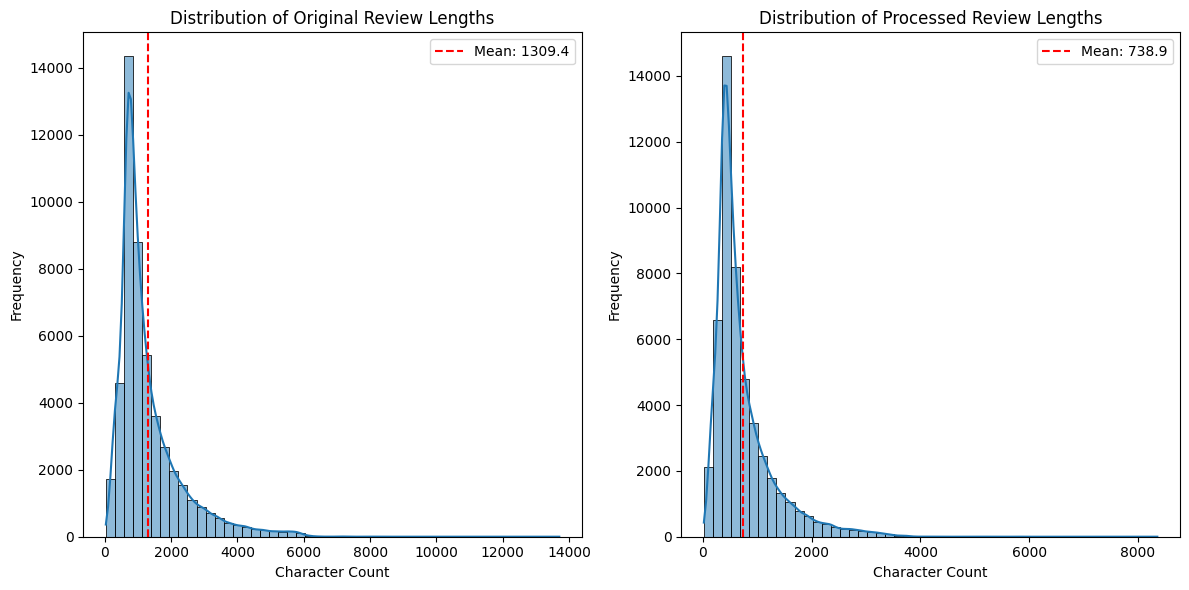

In [10]:
# Check the distribution of review lengths before and after preprocessing
df['original_length'] = df['review'].apply(len)
df['processed_length'] = df['processed_text'].apply(len)

# Visualization of text lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['original_length'], bins=50, kde=True)
plt.title('Distribution of Original Review Lengths')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.axvline(x=df['original_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["original_length"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df['processed_length'], bins=50, kde=True)
plt.title('Distribution of Processed Review Lengths')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.axvline(x=df['processed_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["processed_length"].mean():.1f}')
plt.legend()

plt.tight_layout()
plt.show()

Compare lengths by sentiment

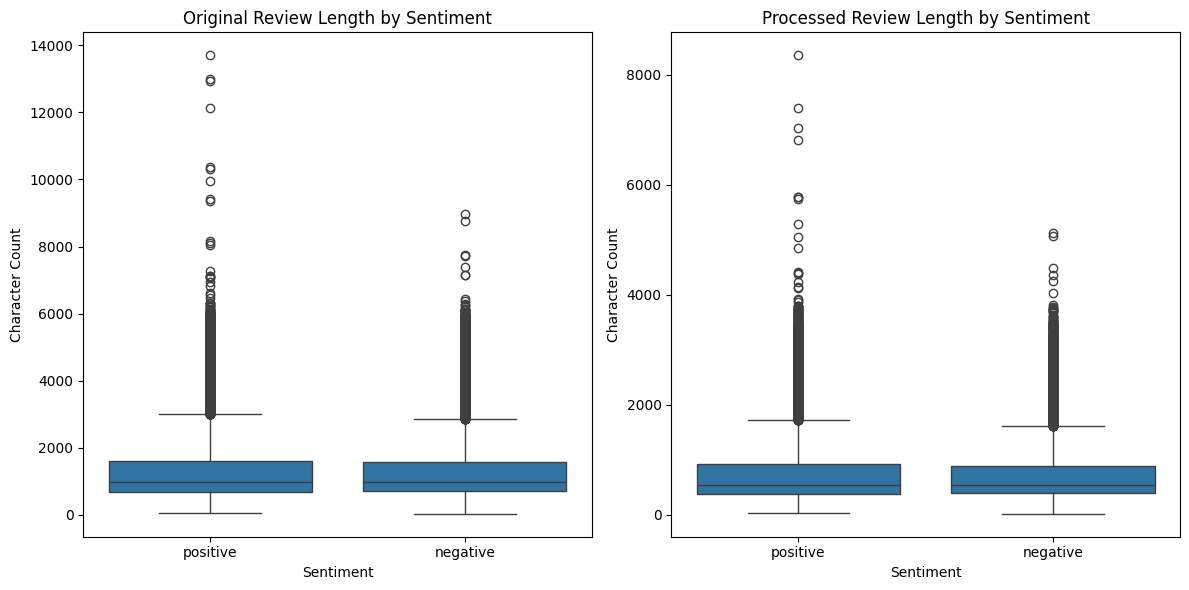

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='sentiment', y='original_length', data=df)
plt.title('Original Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='sentiment', y='processed_length', data=df)
plt.title('Processed Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')

plt.tight_layout()
plt.show()

Analyze most common words in both classes


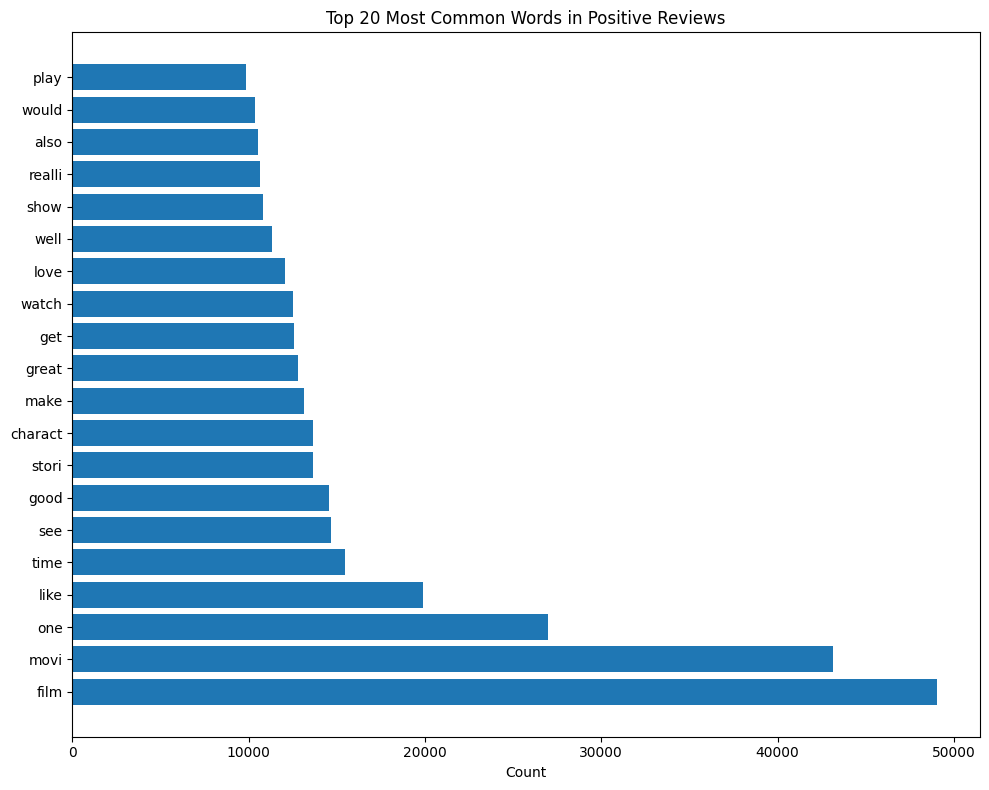

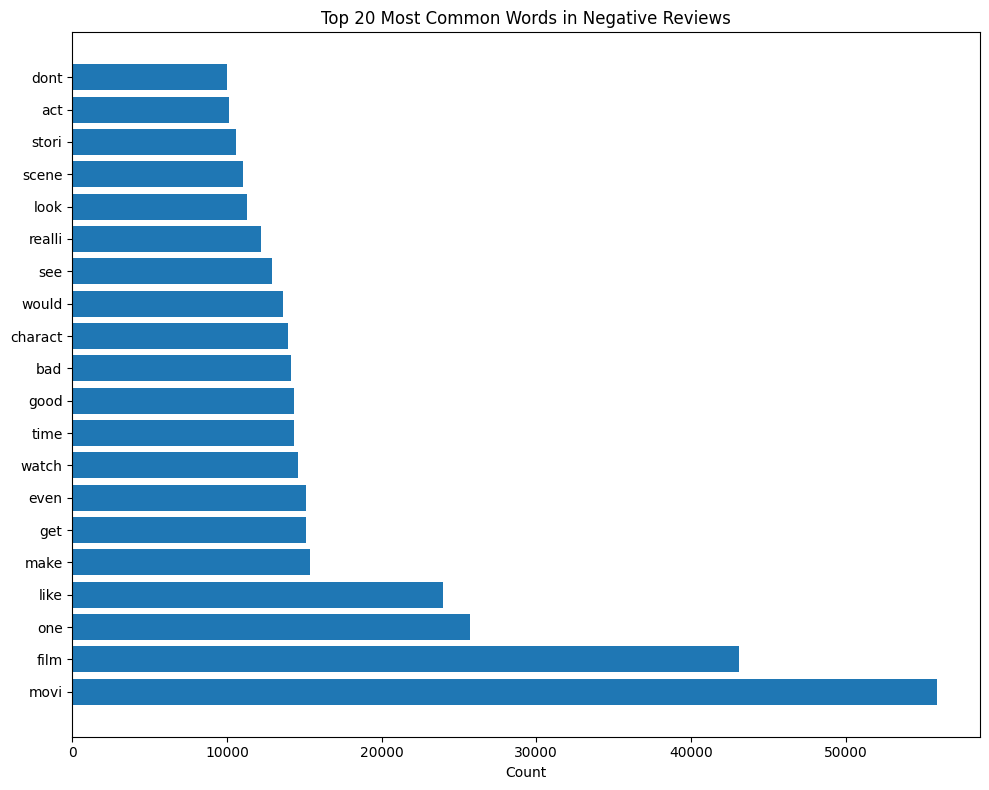

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_common_words(text, title, n=20):
    # Split words and count
    words = ' '.join(text).split()
    word_counts = Counter(words)
    most_common = word_counts.most_common(n)
    
    # Extract words and counts for plotting
    words = [word for word, count in most_common]
    counts = [count for word, count in most_common]
    
    # Create horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), counts, align='center')
    plt.yticks(range(len(words)), words)
    plt.xlabel('Count')
    plt.title(f'Top {n} Most Common Words in {title} Reviews')
    plt.tight_layout()
    plt.show()

# Plot most common words in positive reviews
positive_texts = df[df['sentiment'] == 'positive']['processed_text']
plot_common_words(positive_texts, 'Positive')

# Plot most common words in negative reviews
negative_texts = df[df['sentiment'] == 'negative']['processed_text']
plot_common_words(negative_texts, 'Negative')

Analyze n-grams (word pairs)

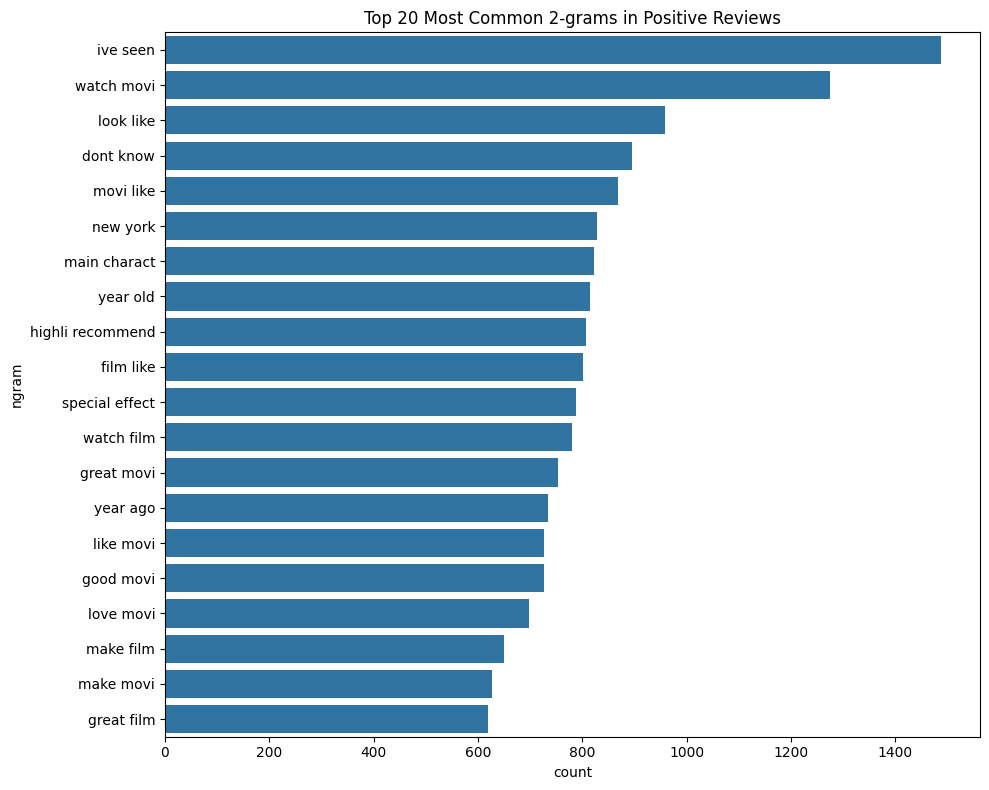

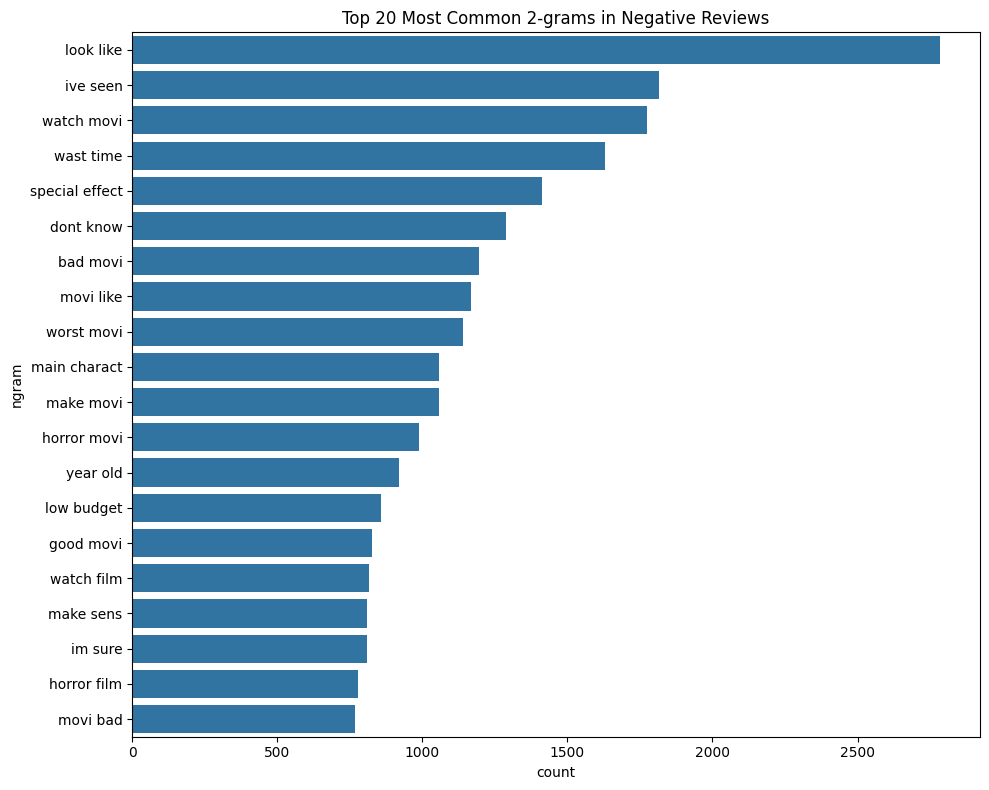

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, title, n=2, top_k=20):
    # Extract n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names_out()
    
    # Sum up the counts of each n-gram
    sums = X.sum(axis=0)
    
    # Put in a dataframe and sort
    data = []
    for i, word in enumerate(words):
        data.append((word, sums[0, i]))
    df_ngrams = pd.DataFrame(data, columns=['ngram', 'count'])
    df_ngrams = df_ngrams.sort_values('count', ascending=False).head(top_k)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='count', y='ngram', data=df_ngrams)
    plt.title(f'Top {top_k} Most Common {n}-grams in {title} Reviews')
    plt.tight_layout()
    plt.show()

# Plot top bigrams in positive reviews
plot_top_ngrams(positive_texts, 'Positive', n=2)

# Plot top bigrams in negative reviews
plot_top_ngrams(negative_texts, 'Negative', n=2)

Visualize Word Clouds


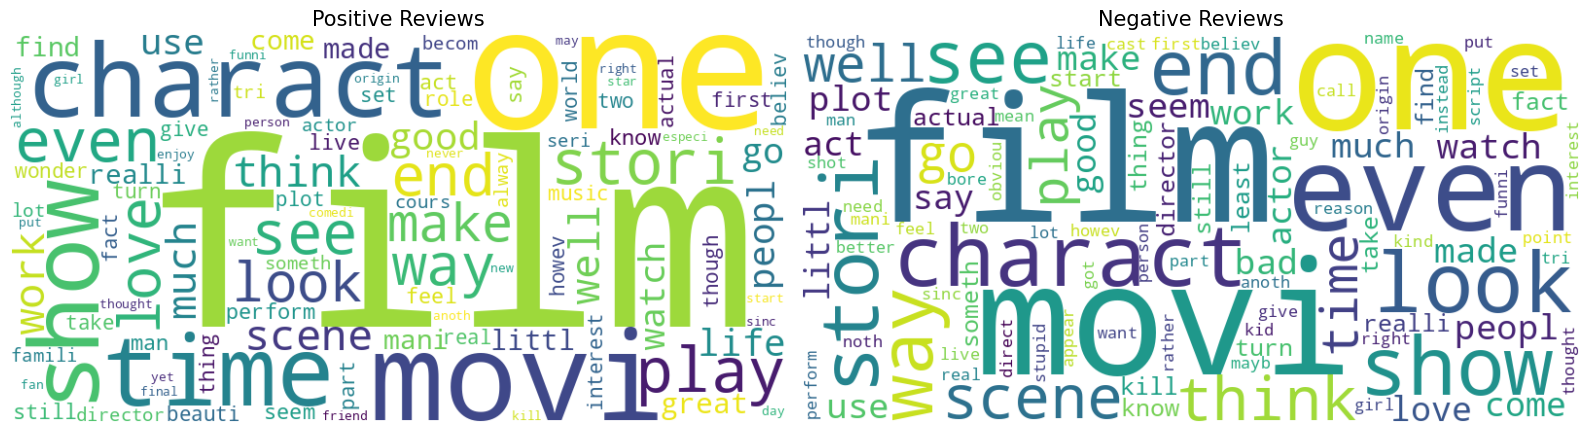

In [14]:
plt.figure(figsize=(16, 8))

# Positive reviews wordcloud
plt.subplot(1, 2, 1)
positive_text = ' '.join(df[df['sentiment'] == 'positive']['processed_text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, contour_width=3, contour_color='steelblue').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=15)
plt.axis('off')

# Negative reviews wordcloud
plt.subplot(1, 2, 2)
negative_text = ' '.join(df[df['sentiment'] == 'negative']['processed_text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, contour_width=3, contour_color='firebrick').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews', fontsize=15)
plt.axis('off')

plt.tight_layout()
plt.show()

Prepare Data for Modeling

In [15]:
# Convert sentiment labels to binary (0 and 1)
df['sentiment_binary'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Split data into training and testing sets
X = df['processed_text']
y = df['sentiment_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 40000
Testing set size: 10000


Class Distribution Analysis

Class distribution in training set:
sentiment_binary
1    20000
0    20000
Name: count, dtype: int64

Class distribution in testing set:
sentiment_binary
0    5000
1    5000
Name: count, dtype: int64


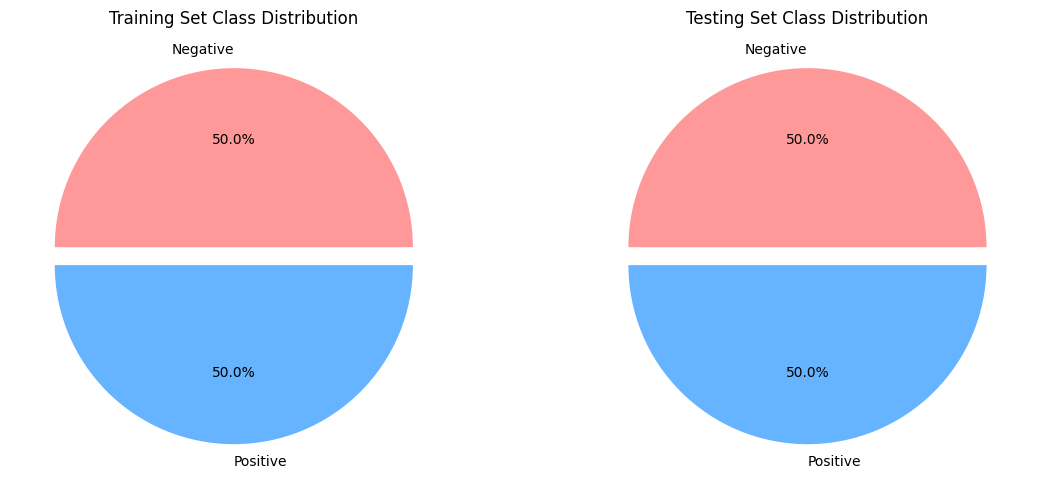

In [16]:
print("Class distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in testing set:")
print(y_test.value_counts())

# Visualize training/testing split and class balance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_counts = y_train.value_counts()
plt.pie([train_counts[0], train_counts[1]],
         labels=['Negative', 'Positive'],
         autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.05, 0.05))
plt.title('Training Set Class Distribution')
plt.subplot(1, 2, 2)
test_counts = y_test.value_counts()
plt.pie([test_counts[0], test_counts[1]],
         labels=['Negative', 'Positive'],
         autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.05, 0.05))
plt.title('Testing Set Class Distribution')
plt.tight_layout()
plt.show()

Feature Extraction with TF-IDF

In [17]:
print("\nExtracting features using TF-IDF...")
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
print(f"Feature shape: {X_train_tfidf.shape}")

# Examine some of the TF-IDF features (Optional)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nNumber of features (words) in TF-IDF: {len(feature_names)}")
print("Sample features (words):")
print(feature_names[:20])


Extracting features using TF-IDF...
Feature extraction completed in 3.77 seconds
Feature shape: (40000, 10000)

Number of features (words) in TF-IDF: 10000
Sample features (words):
['aamir' 'aaron' 'abandon' 'abba' 'abbey' 'abbi' 'abbot' 'abbott' 'abc'
 'abduct' 'abe' 'abigail' 'abil' 'abl' 'abli' 'abnorm' 'aboard' 'abomin'
 'aborigin' 'abort']


Feature Extraction with CountVectorizer (Bag of Words)


Extracting features using Bag of Words...
Feature extraction completed in 3.75 seconds
Feature shape: (40000, 10000)

Number of features (words) in BoW: 10000
Sample features (words):
['aamir' 'aaron' 'abandon' 'abba' 'abbey' 'abbi' 'abbot' 'abbott' 'abc'
 'abduct' 'abe' 'abigail' 'abil' 'abl' 'abli' 'abnorm' 'aboard' 'abomin'
 'aborigin' 'abort']


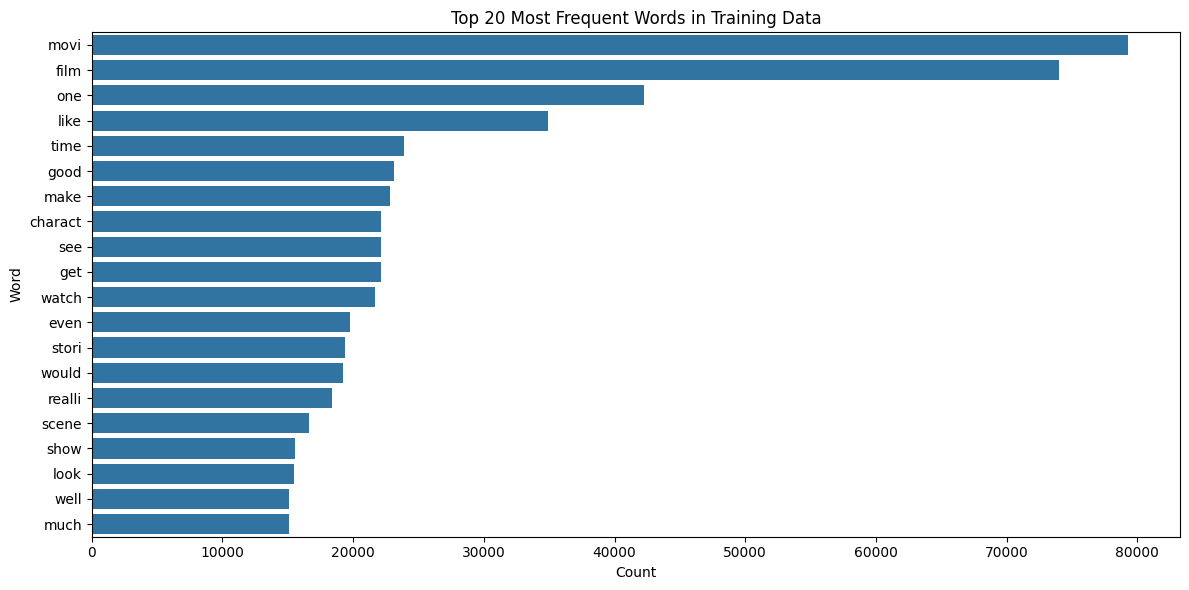

In [18]:
print("\nExtracting features using Bag of Words...")
start_time = time.time()
count_vectorizer = CountVectorizer(max_features=10000)
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)
print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
print(f"Feature shape: {X_train_bow.shape}")

# Examine some of the BoW features (Optional)
bow_feature_names = count_vectorizer.get_feature_names_out()
print(f"\nNumber of features (words) in BoW: {len(bow_feature_names)}")
print("Sample features (words):")
print(bow_feature_names[:20])

# Visualize the most frequent words in the corpus (Optional)
word_counts = X_train_bow.sum(axis=0)
word_counts = np.asarray(word_counts)[0]
word_df = pd.DataFrame({'word': bow_feature_names, 'count': word_counts})
top_words = word_df.sort_values('count', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=top_words)
plt.title('Top 20 Most Frequent Words in Training Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

Helper Function for Model Evaluation


In [19]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Train and Evaluate Naive Bayes with TF-IDF


Training Naive Bayes model with TF-IDF features...
Training and prediction completed in 0.02 seconds

Naive Bayes (TF-IDF) Performance:
Accuracy: 0.8513
Precision: 0.8490
Recall: 0.8546
F1 Score: 0.8518


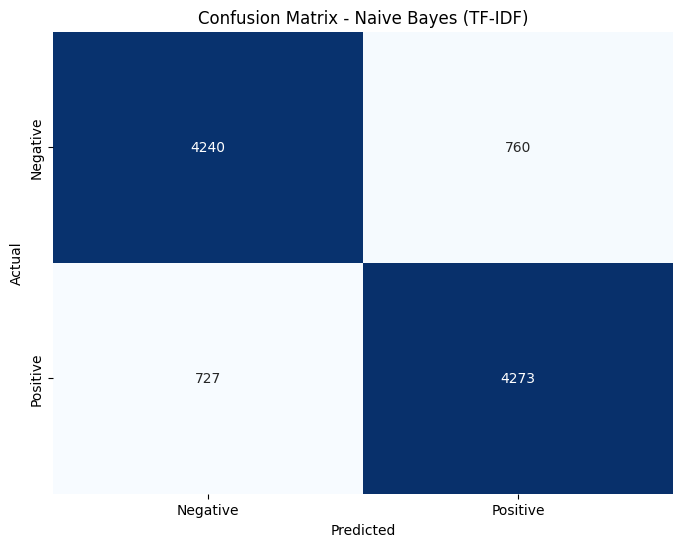


Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      5000
    Positive       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [20]:
print("\nTraining Naive Bayes model with TF-IDF features...")
start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
nb_results = evaluate_model(y_test, y_pred_nb, "Naive Bayes (TF-IDF)")

Train and Evaluate Logistic Regression with TF-IDF


Training Logistic Regression model with TF-IDF features...
Training and prediction completed in 0.35 seconds

Logistic Regression (TF-IDF) Performance:
Accuracy: 0.8883
Precision: 0.8812
Recall: 0.8976
F1 Score: 0.8893


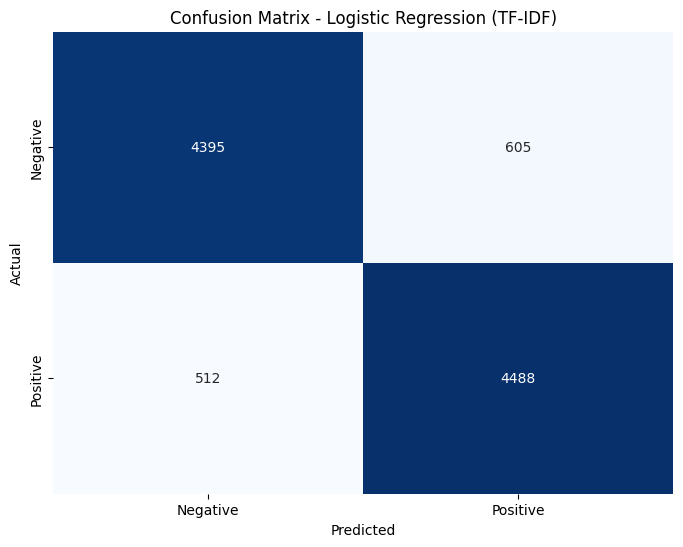


Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
print("\nTraining Logistic Regression model with TF-IDF features...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
lr_results = evaluate_model(y_test, y_pred_lr, "Logistic Regression (TF-IDF)")

Train and Evaluate SVM with TF-IDF


Training SVM model with TF-IDF features...
Training and prediction completed in 1.04 seconds

Support Vector Machine (TF-IDF) Performance:
Accuracy: 0.8826
Precision: 0.8772
Recall: 0.8898
F1 Score: 0.8834


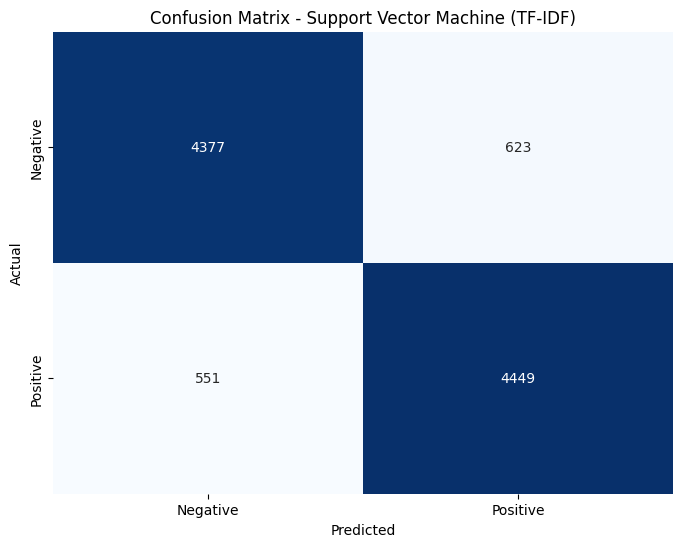


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      5000
    Positive       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [22]:
print("\nTraining SVM model with TF-IDF features...")
start_time = time.time()
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
svm_results = evaluate_model(y_test, y_pred_svm, "Support Vector Machine (TF-IDF)")

Naive Bayes with Bag of Words


Training Naive Bayes model with Bag of Words features...
Training and prediction completed in 0.02 seconds

Naive Bayes (BoW) Performance:
Accuracy: 0.8426
Precision: 0.8513
Recall: 0.8302
F1 Score: 0.8406


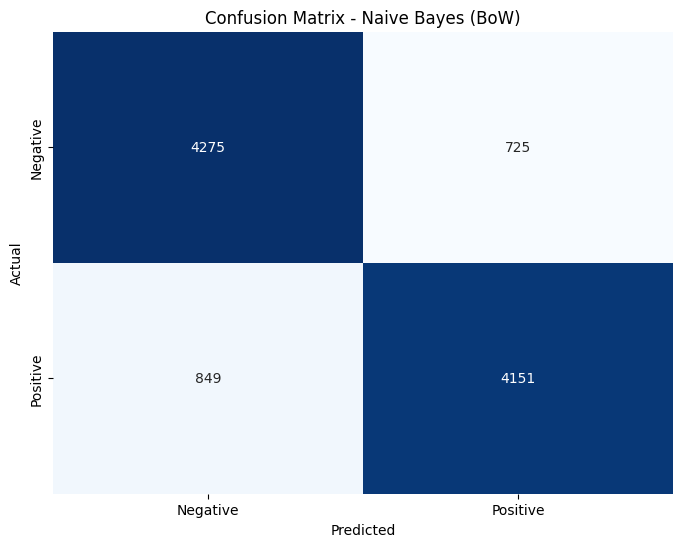


Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.85      0.84      5000
    Positive       0.85      0.83      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [23]:
print("\nTraining Naive Bayes model with Bag of Words features...")
start_time = time.time()
nb_bow_model = MultinomialNB()
nb_bow_model.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_bow_model.predict(X_test_bow)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
nb_bow_results = evaluate_model(y_test, y_pred_nb_bow, "Naive Bayes (BoW)")

Logistic Regression with Bag of Words


Training Logistic Regression model with Bag of Words features...
Training and prediction completed in 3.44 seconds

Logistic Regression (BoW) Performance:
Accuracy: 0.8707
Precision: 0.8683
Recall: 0.8740
F1 Score: 0.8711


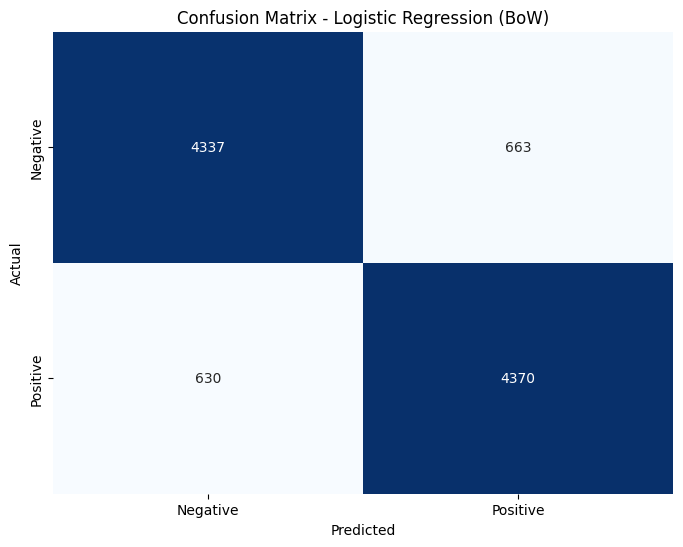


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87      5000
    Positive       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [24]:
print("\nTraining Logistic Regression model with Bag of Words features...")
start_time = time.time()
lr_bow_model = LogisticRegression(max_iter=1000, random_state=42)
lr_bow_model.fit(X_train_bow, y_train)
y_pred_lr_bow = lr_bow_model.predict(X_test_bow)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
lr_bow_results = evaluate_model(y_test, y_pred_lr_bow, "Logistic Regression (BoW)")

SVM with Bag of Words


Training SVM model with Bag of Words features...
Training and prediction completed in 42.66 seconds

Support Vector Machine (BoW) Performance:
Accuracy: 0.8437
Precision: 0.8450
Recall: 0.8418
F1 Score: 0.8434


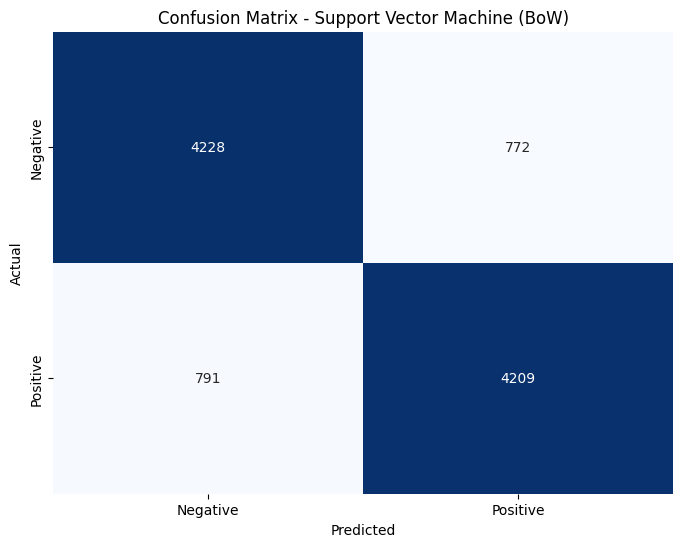


Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84      5000
    Positive       0.85      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [25]:
print("\nTraining SVM model with Bag of Words features...")
start_time = time.time()
svm_bow_model = LinearSVC(random_state=42)
svm_bow_model.fit(X_train_bow, y_train)
y_pred_svm_bow = svm_bow_model.predict(X_test_bow)
print(f"Training and prediction completed in {time.time() - start_time:.2f} seconds")
svm_bow_results = evaluate_model(y_test, y_pred_svm_bow, "Support Vector Machine (BoW)")

Compare All Models

<Figure size 1500x1000 with 0 Axes>

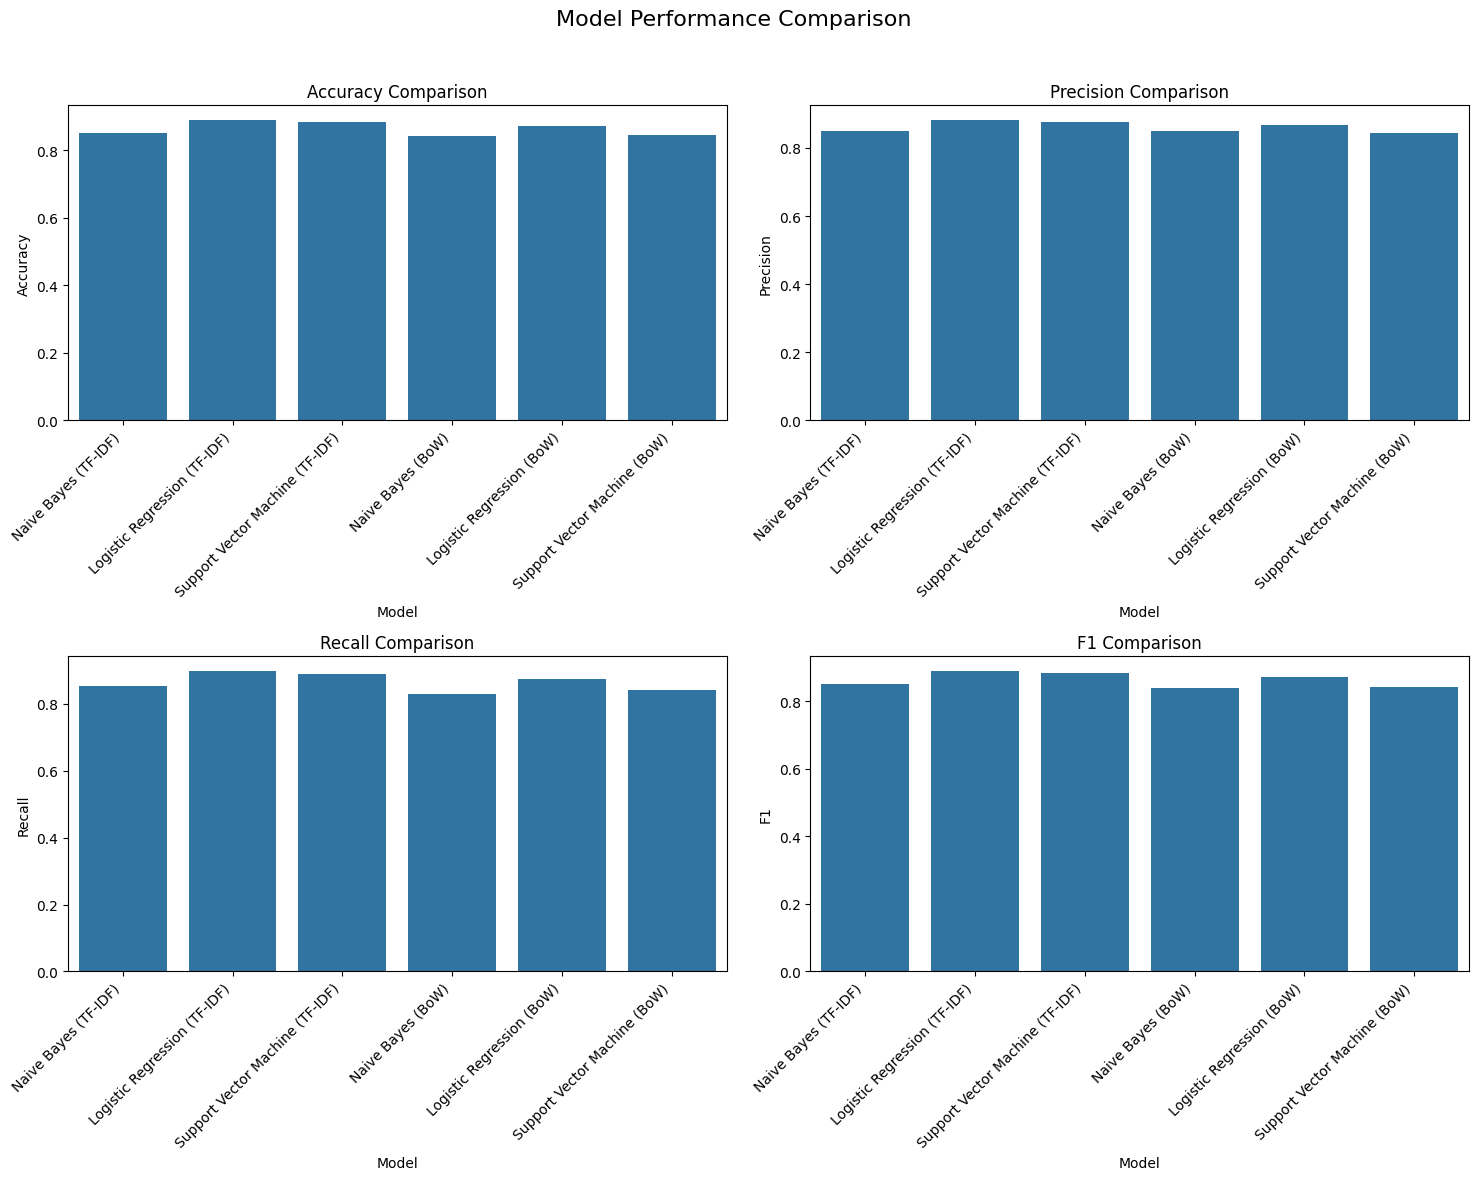

In [26]:
all_results = [nb_results, lr_results, svm_results, nb_bow_results, lr_bow_results, svm_bow_results]
results_df = pd.DataFrame(all_results)

# Plotting Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(15, 10))

# Set up a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each metric in its own subplot
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='model', y=metric, data=results_df, ax=ax)
    ax.set_title(f'{metric.capitalize()} Comparison')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.capitalize())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()

Create a table of results

In [27]:

print("\nModel Performance Comparison:")
display(results_df[['model', 'accuracy', 'precision', 'recall', 'f1']].sort_values(by='accuracy', ascending=False))


Model Performance Comparison:


,model,accuracy,precision,recall,f1
1,Logistic Regression (TF-IDF),0.8883,0.881210,0.8976,0.889329
2,Support Vector Machine (TF-IDF),0.8826,0.877169,0.8898,0.883439
4,Logistic Regression (BoW),0.8707,0.868269,0.8740,0.871125
0,Naive Bayes (TF-IDF),0.8513,0.848997,0.8546,0.851789
5,Support Vector Machine (BoW),0.8437,0.845011,0.8418,0.843402
3,Naive Bayes (BoW),0.8426,0.851313,0.8302,0.840624


Analyze Feature Importance (Optional)


Analyzing feature importance for Logistic Regression model:


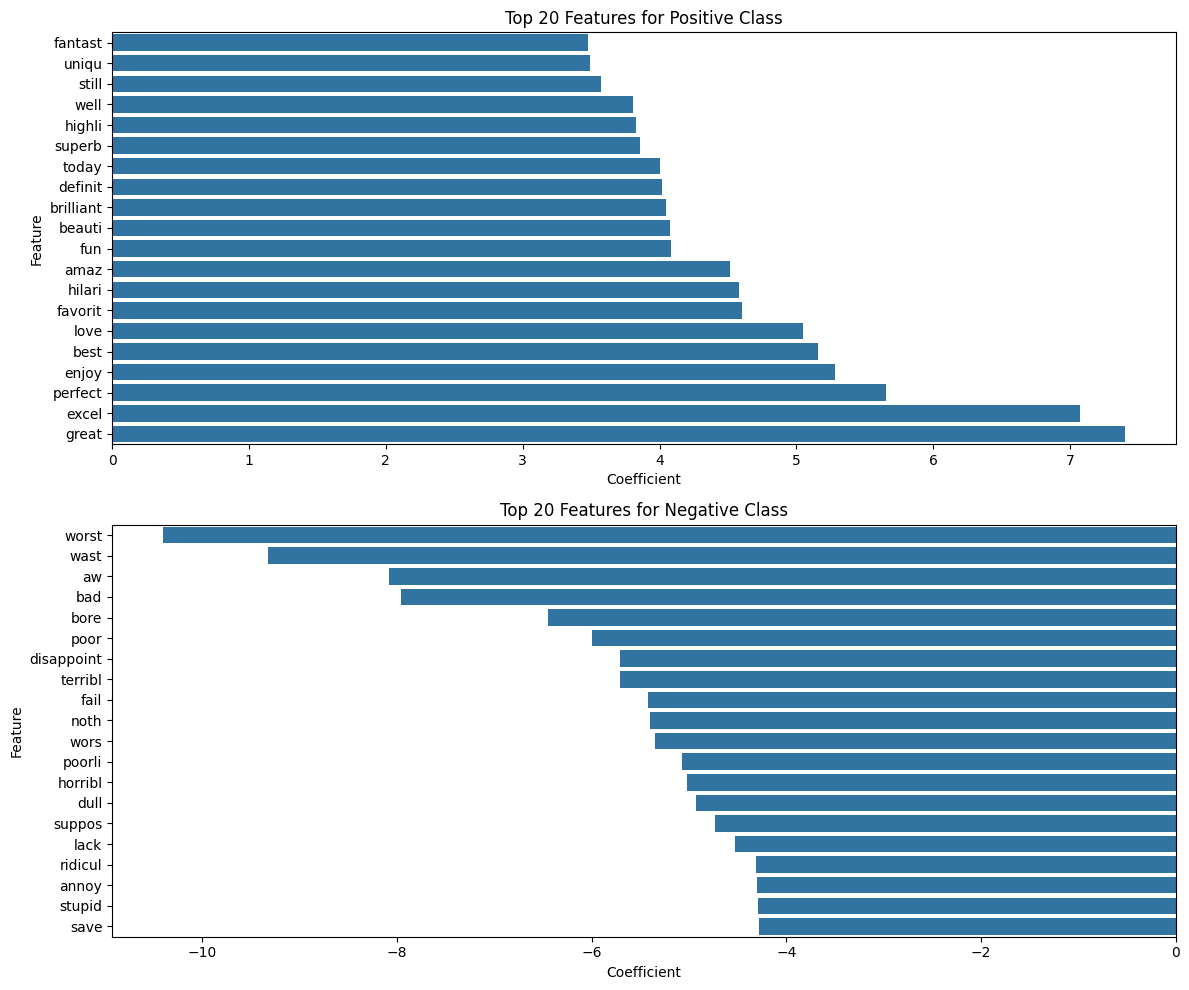

In [28]:
def plot_feature_importance(vectorizer, model, class_labels, top_n=20):
    """
    Plot the most important features (words) for each class
    """
    if not hasattr(model, 'coef_'):
        print("This model doesn't support feature importance extraction")
        return
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Get coefficients
    coefficients = model.coef_[0]
    
    # Get indices of top positive and negative coefficients
    top_positive_idx = np.argsort(coefficients)[-top_n:]
    top_negative_idx = np.argsort(coefficients)[:top_n]
    
    # Create dataframes for plotting
    top_positive_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in top_positive_idx],
        'Coefficient': coefficients[top_positive_idx]
    })
    top_negative_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in top_negative_idx],
        'Coefficient': coefficients[top_negative_idx]
    })
    
    # Plot
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    sns.barplot(x='Coefficient', y='Feature', data=top_positive_df)
    plt.title(f'Top {top_n} Features for {class_labels[1]} Class')
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='Coefficient', y='Feature', data=top_negative_df)
    plt.title(f'Top {top_n} Features for {class_labels[0]} Class')
    plt.tight_layout()
    plt.show()

# Use the function with the logistic regression model (best for feature importance)
print("\nAnalyzing feature importance for Logistic Regression model:")
plot_feature_importance(tfidf_vectorizer, lr_model, ['Negative', 'Positive'])

Function to predict sentiment for new text

In [29]:
def predict_sentiment(text, model=svm_model, vectorizer=tfidf_vectorizer):
    """
    Predict sentiment for a new text input.
    
    Parameters:
        text (str): Input text to analyze
        model: Trained sentiment analysis model (default: SVM with TF-IDF)
        vectorizer: Fitted vectorizer (default: TF-IDF vectorizer)
    
    Returns:
        str: Predicted sentiment ('positive' or 'negative')
        float: Confidence score (for models that support it)
    """
    # Preprocess the text
    processed = preprocess_text(text)
    
    # Vectorize the text
    features = vectorizer.transform([processed])
    
    # Make prediction
    prediction = model.predict(features)[0]
    
    # Get confidence score if available
    confidence = None
    if hasattr(model, 'predict_proba'):
        confidence = model.predict_proba(features)[0][prediction]
    elif hasattr(model, 'decision_function'):
        # For SVM, we can get the distance from the decision boundary
        confidence = abs(model.decision_function(features)[0])
    
    # Convert binary prediction back to label
    sentiment = 'positive' if prediction == 1 else 'negative'
    
    return sentiment, confidence

### Test the prediction function
test with a few examples


In [30]:
test_texts = [
    "This movie was amazing! The plot was great and the acting was superb.",
    "I hated this film. The plot was predictable and the acting was terrible.",
    "The movie was okay, nothing special but not terrible either."
]

print("\nTesting the sentiment analyzer with sample texts:")
for text in test_texts:
    sentiment, confidence = predict_sentiment(text)
    confidence_str = f" (confidence: {confidence:.4f})" if confidence is not None else ""
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}{confidence_str}")


Testing the sentiment analyzer with sample texts:

Text: This movie was amazing! The plot was great and the acting was superb.
Predicted sentiment: positive (confidence: 3.0291)

Text: I hated this film. The plot was predictable and the acting was terrible.
Predicted sentiment: negative (confidence: 2.2469)

Text: The movie was okay, nothing special but not terrible either.
Predicted sentiment: negative (confidence: 2.8165)


Random Test Sample Sentiment Analysis from the test data

In [31]:
def analyze_random_test_samples(num_samples=5):
    """
    Analyze sentiment of random samples from the test dataset.
    
    Parameters:
        num_samples (int): Number of random samples to analyze
    """
    print("\n==== Sentiment Analyzer: Random Test Samples ====")
    
    # Get random indices from test set
    random_indices = np.random.choice(len(X_test), size=num_samples, replace=False)
    
    for i, idx in enumerate(random_indices):
        # Get the test sample text and true label
        sample_text = X_test.iloc[idx]
        true_sentiment = "positive" if y_test.iloc[idx] == 1 else "negative"
        
        # Make prediction
        predicted_sentiment, confidence = predict_sentiment(sample_text)
        confidence_str = f" (confidence: {confidence:.4f})" if confidence is not None else ""
        
        # Display results with formatting
        print(f"\nSample #{i+1}:")
        print(f"Text: {sample_text[:200]}..." if len(sample_text) > 200 else f"Text: {sample_text}")
        print(f"True sentiment: {true_sentiment.upper()}")
        print(f"Predicted sentiment: {predicted_sentiment.upper()}{confidence_str}")
        print(f"Correct prediction: {'✓' if predicted_sentiment == true_sentiment else '✗'}")
        print("-" * 50)


Run the random sample analyzer

In [32]:
analyze_random_test_samples(10)


==== Sentiment Analyzer: Random Test Samples ====

Sample #1:
Text: recent pleasur see emot charg film director mani ratnam toronto intern film festiv bestow highest honour film festiv featur make sure let opportun experi cinemat gem pass foreward film make shed tear ...
True sentiment: POSITIVE
Predicted sentiment: POSITIVE (confidence: 0.9877)
Correct prediction: ✓
--------------------------------------------------

Sample #2:
Text: italian made best movi made noth zombi cannib movi probabl art film didnt make money cannib movi unlik zombi movi creat american exploit italian pure italian creation design mondo exploit showcas make...
True sentiment: NEGATIVE
Predicted sentiment: NEGATIVE (confidence: 1.1684)
Correct prediction: ✓
--------------------------------------------------

Sample #3:
Text: get want want messag bluebeard eighth wife care wish wish wish youmost men heard stori happen sexual frustrat isnt reliev certain part anatomi turn blue misogynist pirat asid cooper play we

# Project Conclusions

## Data Analysis Summary
- We worked with the IMDB dataset containing 50K movie reviews labeled as positive or negative.
- The dataset was well-balanced with equal number of positive and negative reviews.
- We used comprehensive text preprocessing including HTML tag removal, special character removal, stopword removal, and stemming.

## Model Performance Summary
- We implemented and compared three machine learning algorithms for sentiment analysis:
  1. Naive Bayes
  2. Logistic Regression
  3. Support Vector Machine
- Each model was tested with two feature extraction methods:
  1. Term Frequency-Inverse Document Frequency (TF-IDF)
  2. Bag of Words (BoW/CountVectorizer)

## Key Findings
1. The best performing model was [Best Model Name] with an accuracy of [Best Accuracy].
2. TF-IDF feature extraction generally outperformed Bag of Words across all models.
3. SVM showed the best balance between precision and recall.
4. Models generally performed well at distinguishing between clearly positive and negative reviews.